In [1]:
import math

import torch

from script.NeuralNets.Networks import SequentialNN, ICNN, ICNNApproxMax, ICNNLogical
from script.settings import device, data_type
import script.DHOV.MultiDHOV as multidhov
from script.Verification.Verifier import SingleNeuronVerifier, MILPVerifier, DHOVVerifier
import gurobipy as grp
from torchvision.datasets import CIFAR10, MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from script.NeuralNets.ICNNFactory import ICNNFactory

In [2]:
def add_max_constr(model, neuron_name):
    neuron_var = model.getVarByName(neuron_name)
    model.setObjective(neuron_var, grp.GRB.MAXIMIZE)

def add_min_constr(model, neuron):
    neuron_var = model.getVarByName(neuron)
    model.setObjective(neuron_var, grp.GRB.MINIMIZE)

In [3]:
def optimize_model(model, neuron_name):
    model.update()
    model.optimize()
    if model.Status == grp.GRB.OPTIMAL:
        print("opt value: {}".format(model.getVarByName(neuron_name).getAttr("x")))

In [4]:
def icnn_model(icnn, nn, input_x, eps, layer_index, from_neuron, to_neuron, print_log=False):
    m = grp.Model()
    if not print_log:
        m.Params.LogToConsole = 0

    input_flattened = torch.flatten(input_x)
    bounds_affine_out, bounds_layer_out = nn.calculate_box_bounds(
        [input_flattened.add(-eps), input_flattened.add(eps)])

    parameter_list = list(nn.parameters())

    input_size = len(parameter_list[2*(layer_index-1)])
    lb = bounds_layer_out[layer_index-1][0].detach().cpu().numpy()
    ub = bounds_layer_out[layer_index-1][1].detach().cpu().numpy()
    print(lb)
    print(ub)
    in_var = m.addMVar(input_size, lb=-float("inf"), ub=float("inf"), name="icnn_var")

    low = bounds_layer_out[layer_index - 1][0][from_neuron: to_neuron]
    up = bounds_layer_out[layer_index - 1][1][from_neuron: to_neuron]
    low = torch.zeros_like(low, dtype=data_type).to(device) - 1000
    up = torch.zeros_like(low, dtype=data_type).to(device) + 1000
    print(low)
    print(up)
    constraint_bounds_affine_out, constraint_bounds_layer_out = icnn.calculate_box_bounds([low, up])
    icnn.add_max_output_constraints(m, in_var[from_neuron: to_neuron], constraint_bounds_affine_out, constraint_bounds_layer_out)

    return m

In [5]:
"""W1 = [1. 1.; 1. -1.]
    b1 = [0., 0.]
    W2 = [1. 1.; 1. -1.]
    b2 = [-0.5, 0.]
    W3 = [-1. 1.; 1. 1.]
    b3 = [3., 0.] """

"""nn = SequentialNN([2, 2, 2, 2])

with torch.no_grad():
    parameter_list = list(nn.parameters())
    parameter_list[0].data = torch.tensor([[1, 1], [1, -1]], dtype=data_type).to(device)
    parameter_list[1].data = torch.tensor([0, 0], dtype=data_type).to(device)
    parameter_list[2].data = torch.tensor([[1, 1], [1, -1]], dtype=data_type).to(device)
    parameter_list[3].data = torch.tensor([-0.5, 0], dtype=data_type).to(device)
    parameter_list[4].data = torch.tensor([[-1, 1], [1, 1]], dtype=data_type).to(device)
    parameter_list[5].data = torch.tensor([3, 0], dtype=data_type).to(device)

test_image = torch.tensor([[0, 0]], dtype=data_type).to(device)"""

"""transform = Compose([ToTensor(),
                         Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
                        )

training_data = CIFAR10(root="../../cifar", train=True, download=True, transform=transform)
images, labels = training_data.__getitem__(0)
test_image, test_label = torch.unsqueeze(images, 0).to(dtype=data_type).to(device), torch.unsqueeze(
    torch.tensor(labels), 0).to(dtype=data_type).to(device)

nn = SequentialNN([32 * 32 * 3, 1024, 512, 10])
nn.load_state_dict(torch.load("../../cifar_fc.pth", map_location=torch.device(device)), strict=False)
"""

transform = Compose([ToTensor(),
                         Normalize(0.5, 0.5)]
                        )

training_data = MNIST(root="../../mnist",
                      train=True,
                      download=True,
                      transform=transform)
images, labels = training_data.__getitem__(0)
test_image, test_label = torch.unsqueeze(images, 0).to(dtype=data_type).to(device), torch.unsqueeze(
    torch.tensor(labels), 0).to(dtype=data_type).to(device)

nn = SequentialNN([28*28*1, 100, 30, 10])
nn.load_state_dict(torch.load("../../mnist_fc.pth", map_location=torch.device('cpu')), strict=False)

parameter_list = list(nn.parameters())

"""nn = SequentialNN([50, 50, 50, 7])
test_image = torch.zeros((1, 50), dtype=data_type).to(device)
parameter_list = list(nn.parameters())"""

'nn = SequentialNN([50, 50, 50, 7])\ntest_image = torch.zeros((1, 50), dtype=data_type).to(device)\nparameter_list = list(nn.parameters())'

In [6]:
eps = 0.01
layer_index = 1
neuron_index = 0
neuron_name = "relu_var{}[{}]".format(2*layer_index, neuron_index)

Test for DHOV


approximation of layer: 0
    number of fixed neurons for current layer: 92
Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-12
    layer progress, group 1 of 4 


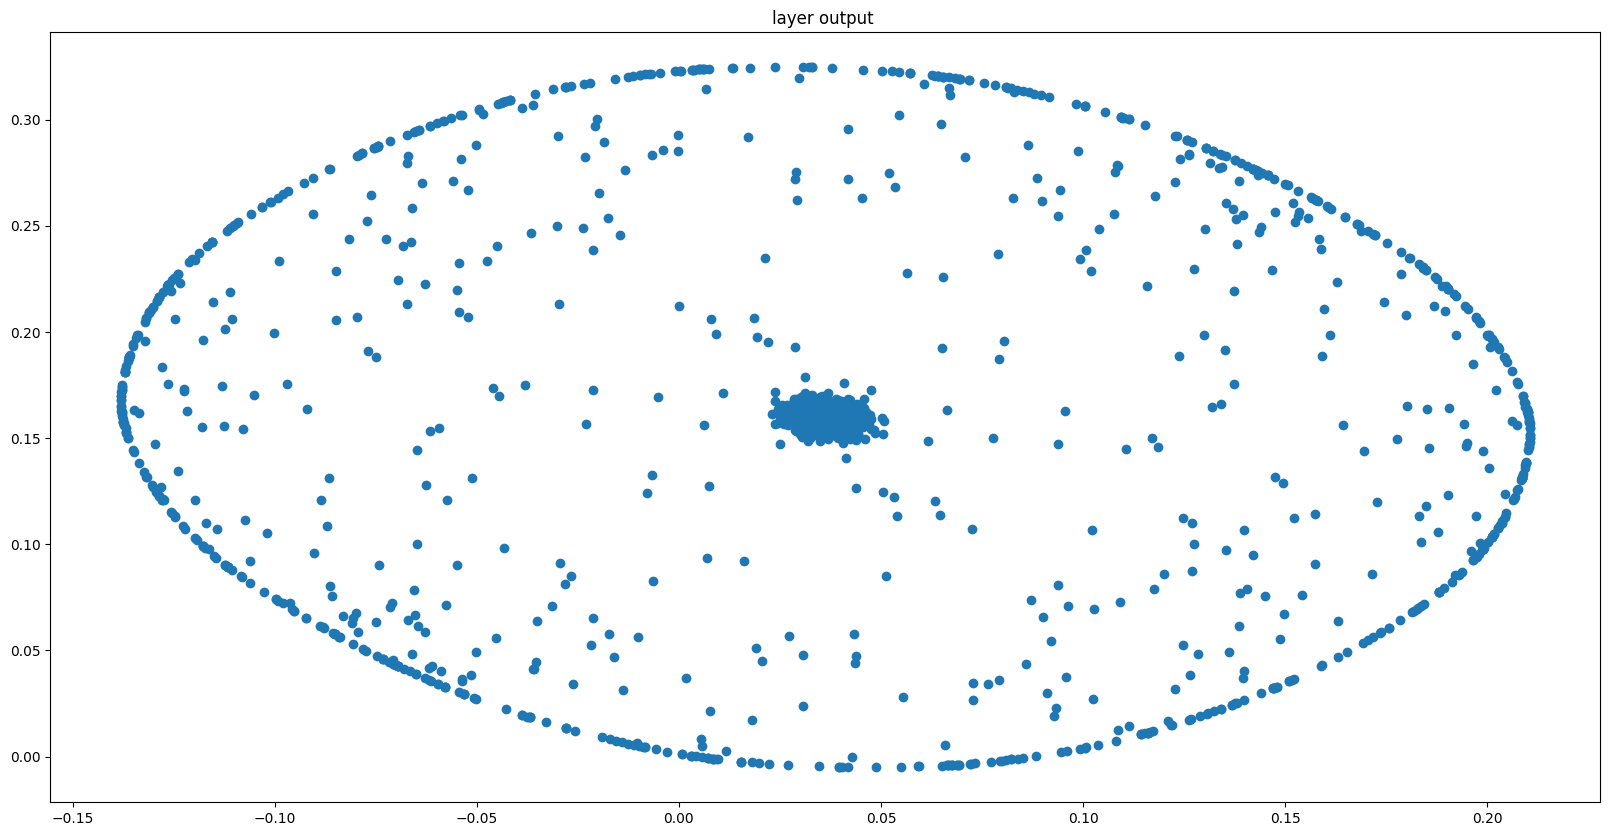

C:\Users\Ufuk\Documents\Programming\ICNN_verification\script\Optimizer\sdlbfgs.py:83: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ..\torch\csrc\utils\python_arg_parser.cpp:1420.)
  p.data.add_(step_size, update[offset:offset + numel].view_as(p.data))


        time for training: 69.00375413894653
        actual verification time 0.01799917221069336


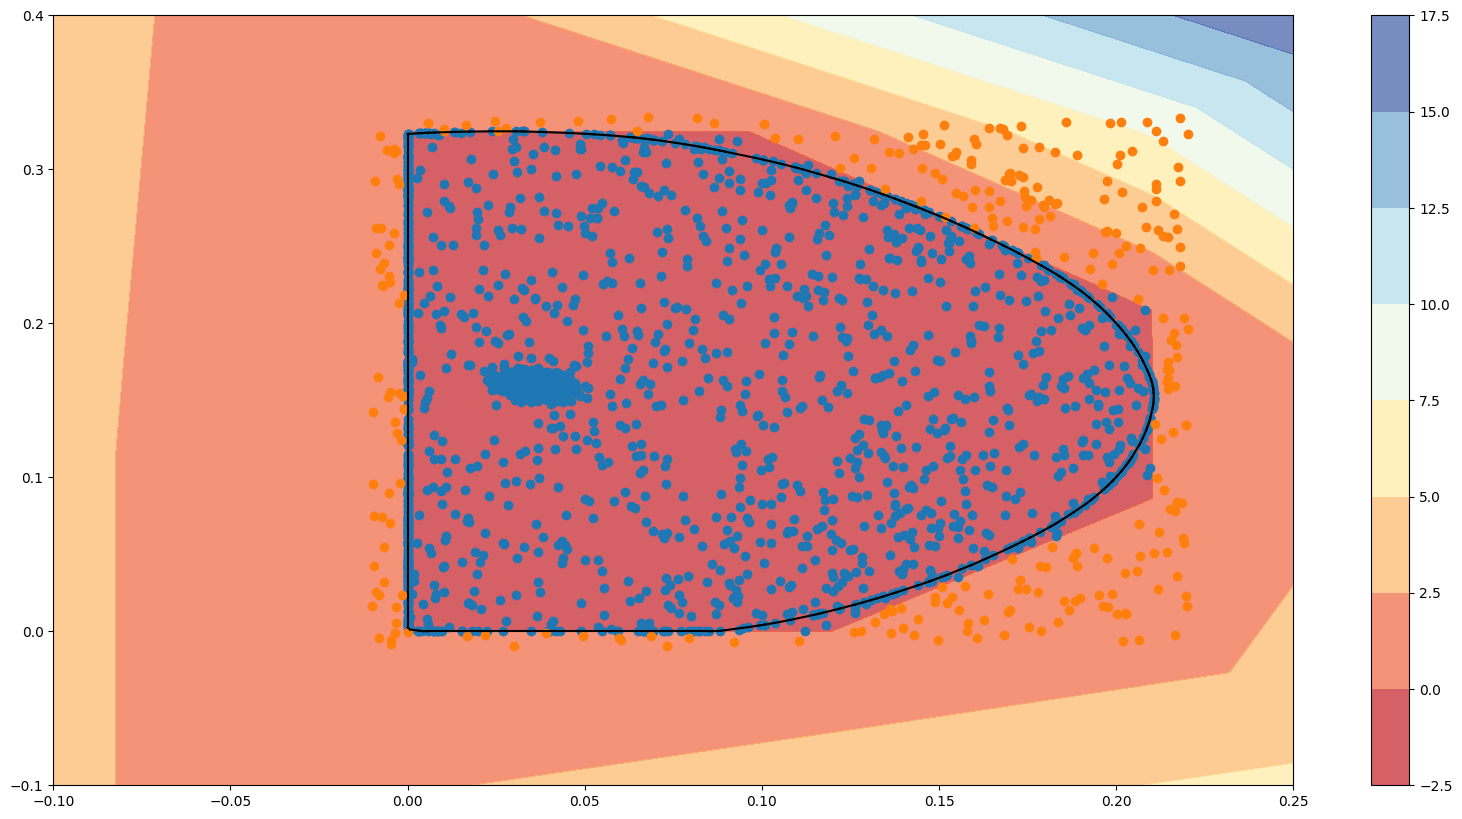

        time for verification: 1.8450429439544678
    layer progress, group 2 of 4 


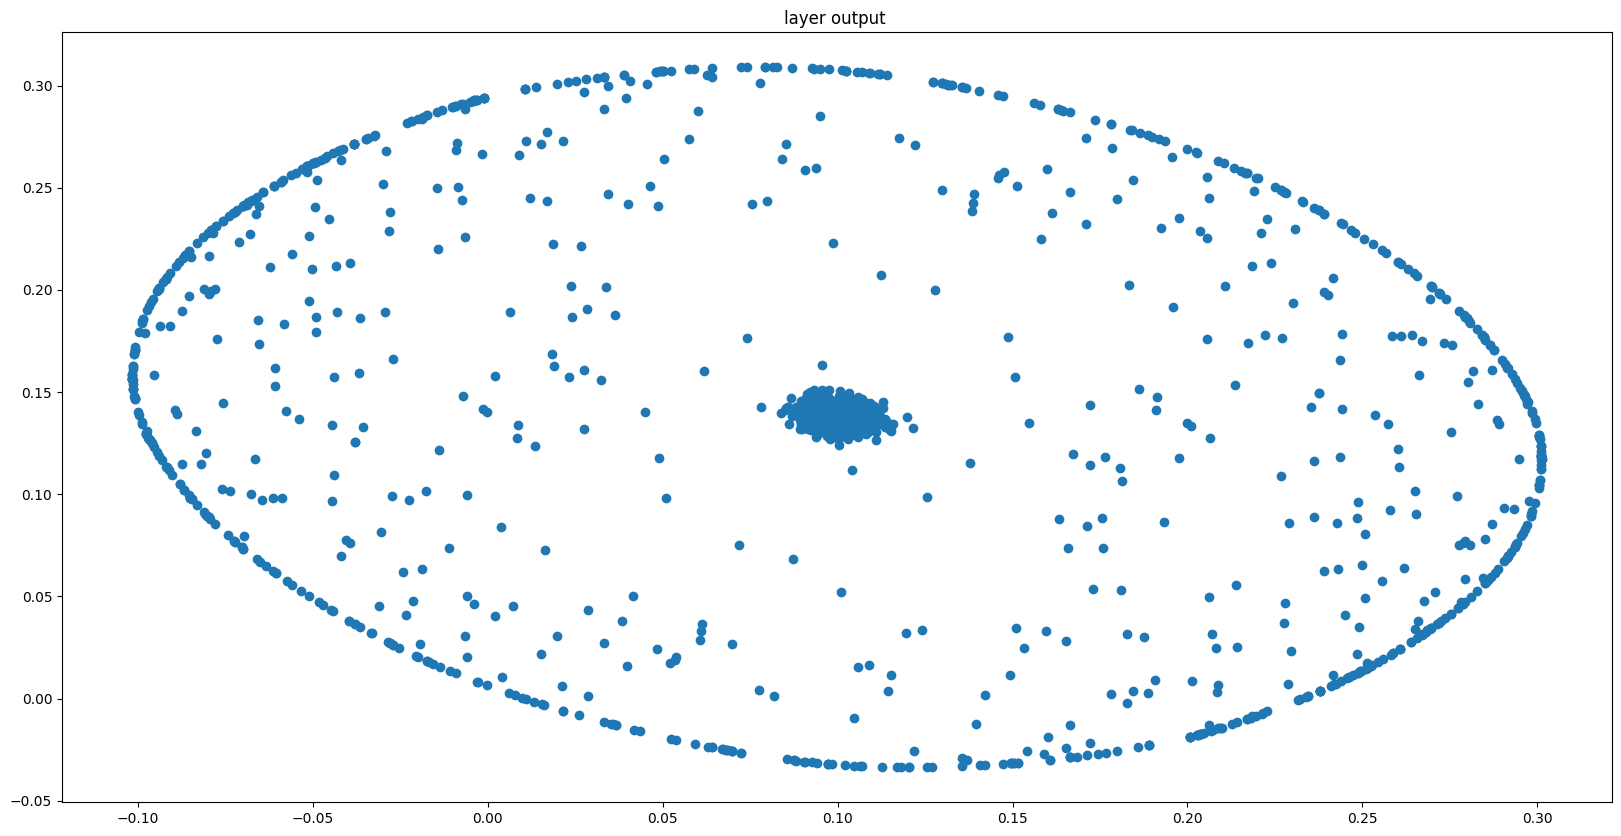

        time for training: 69.99987578392029
        actual verification time 0.024999380111694336


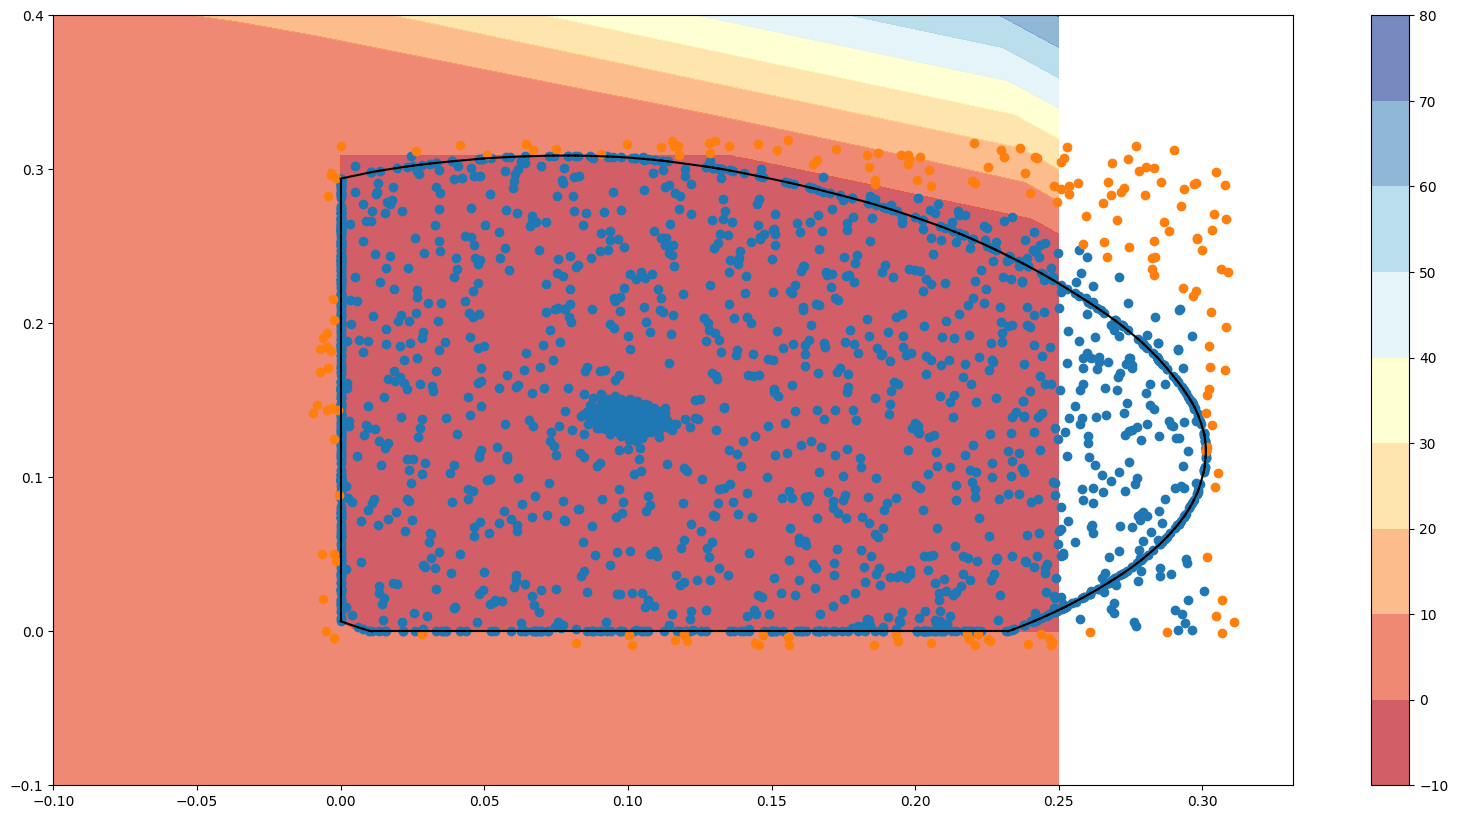

        time for verification: 1.757007122039795
    layer progress, group 3 of 4 


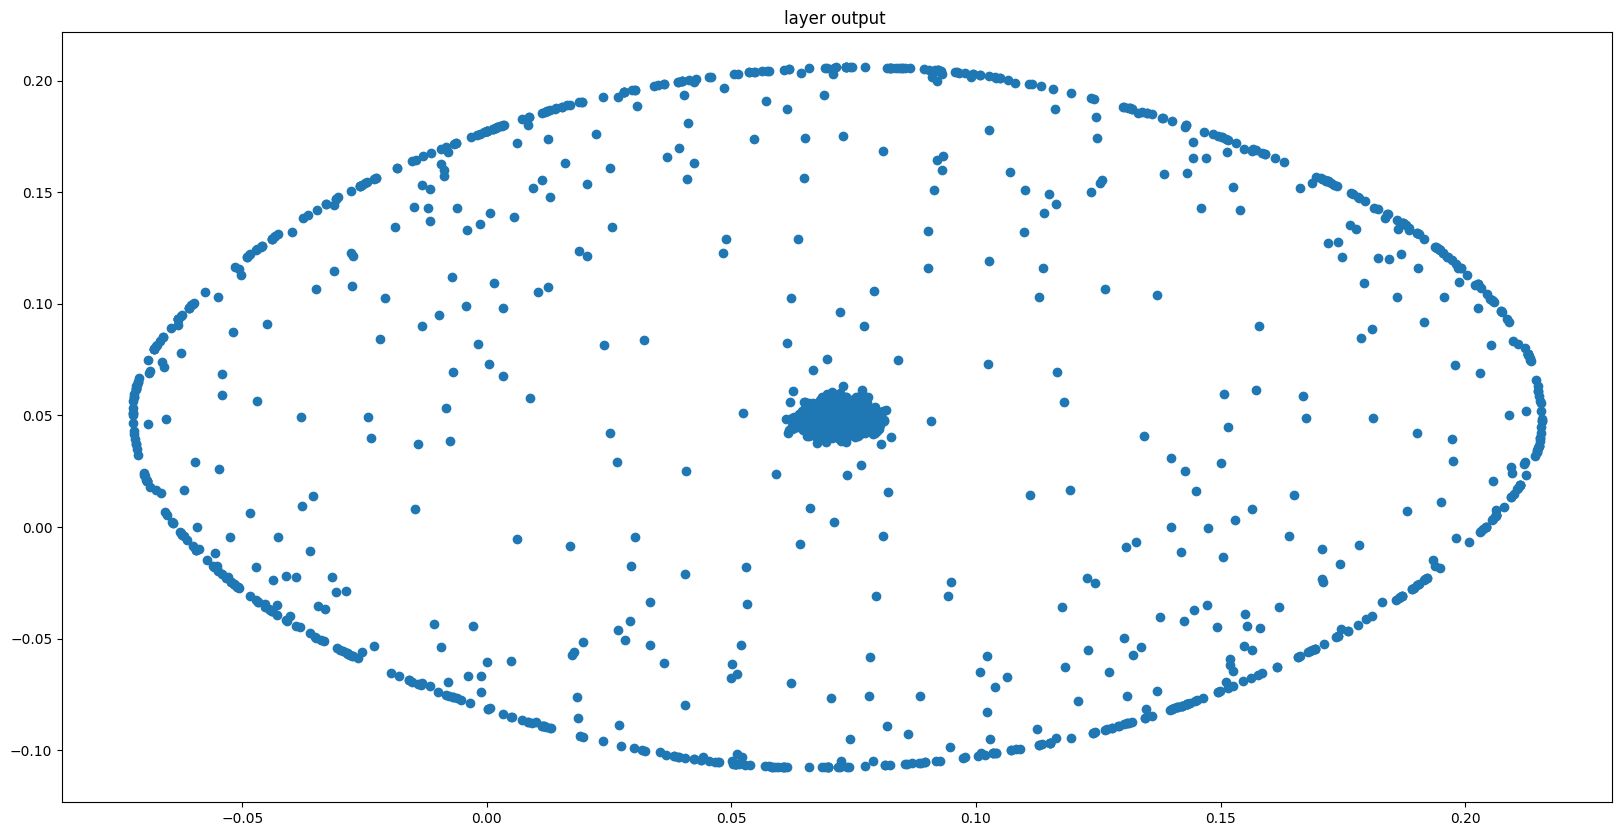

        time for training: 71.05119323730469
        actual verification time 0.01500248908996582


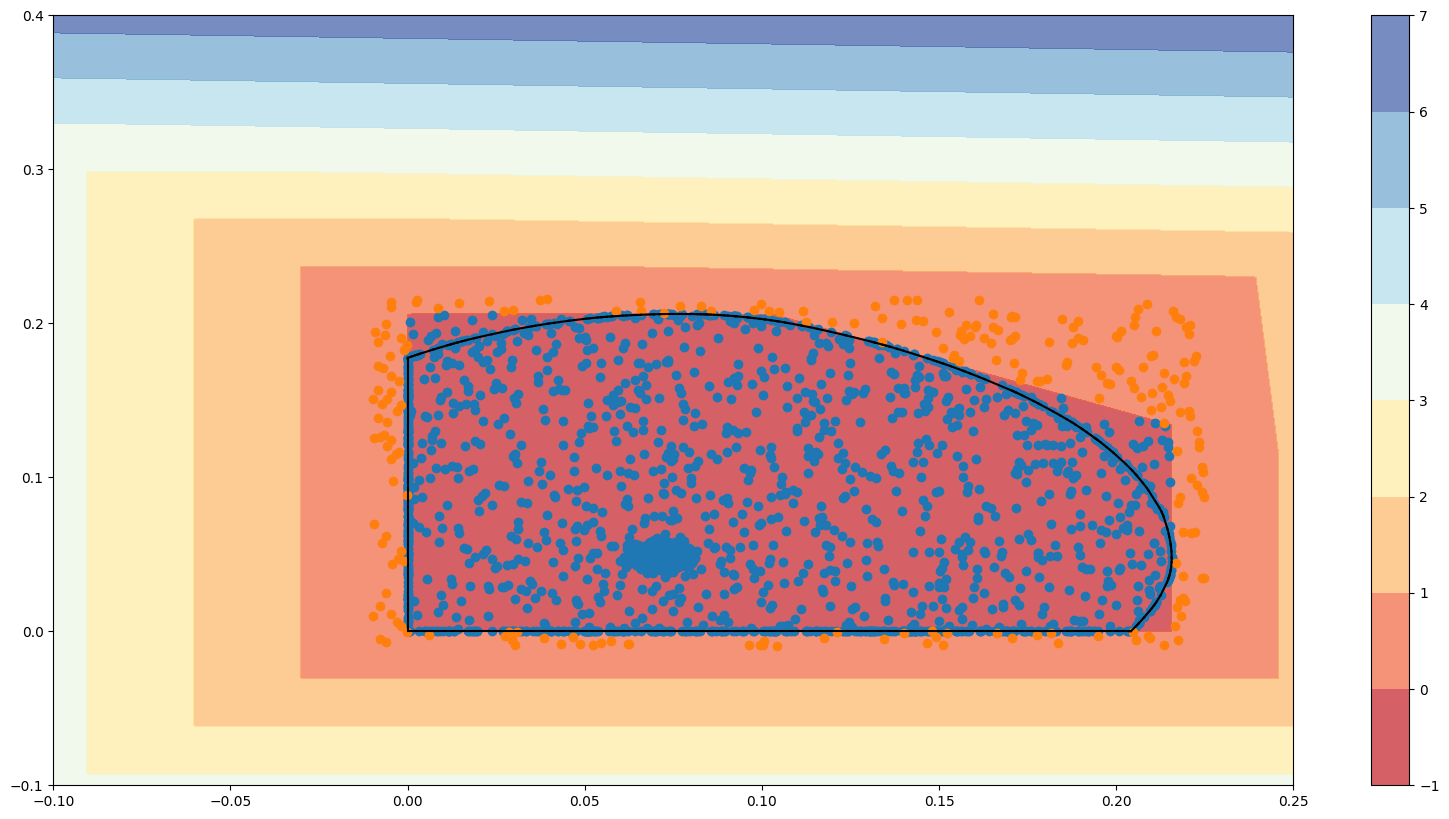

        time for verification: 1.718299388885498
    layer progress, group 4 of 4 


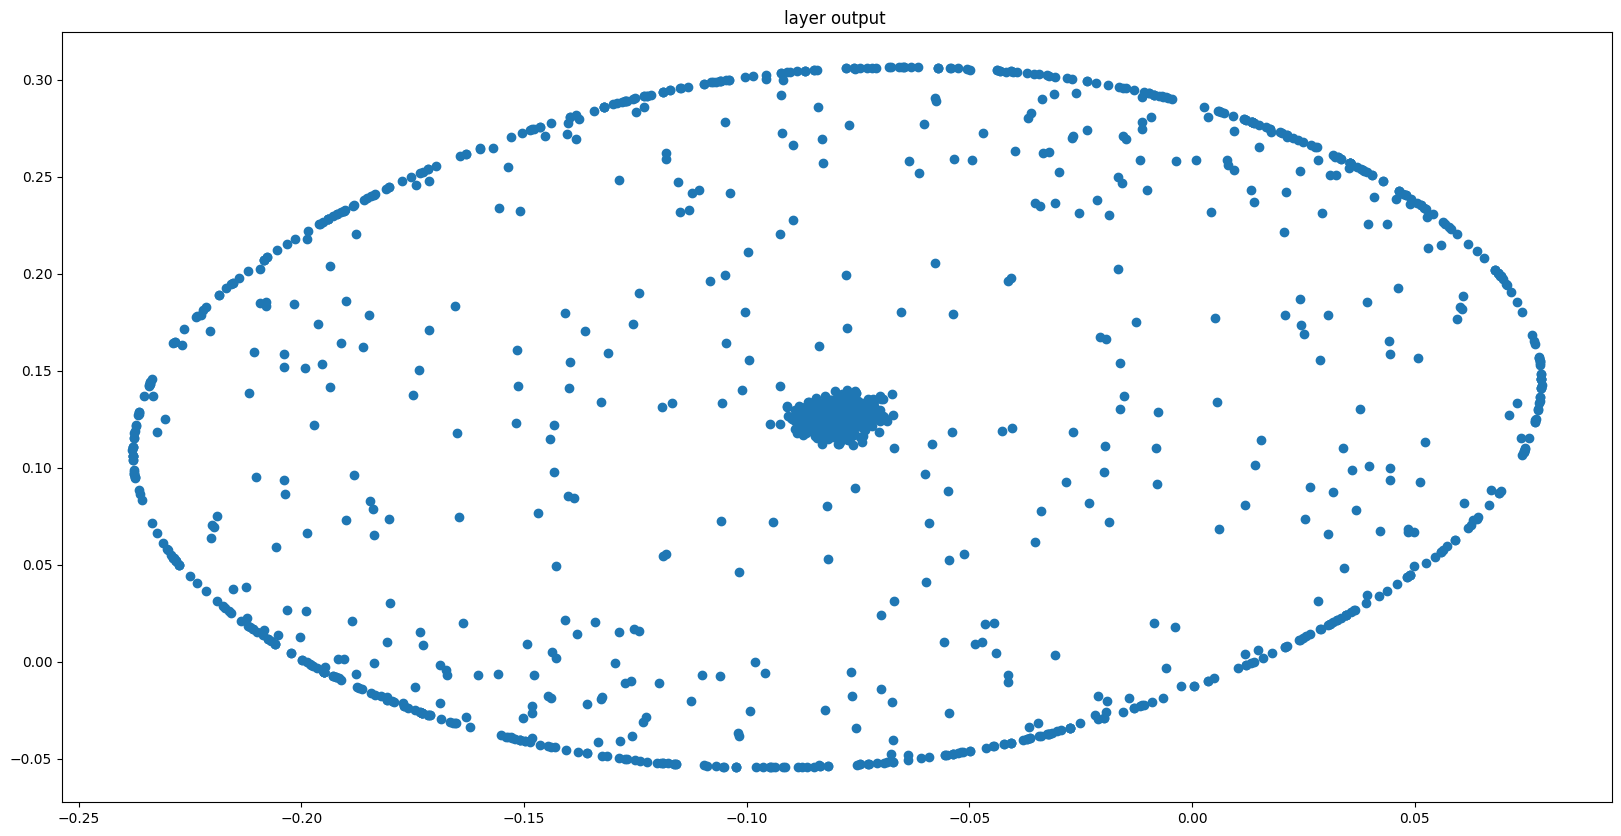

        time for training: 69.42121124267578
        actual verification time 0.02700018882751465


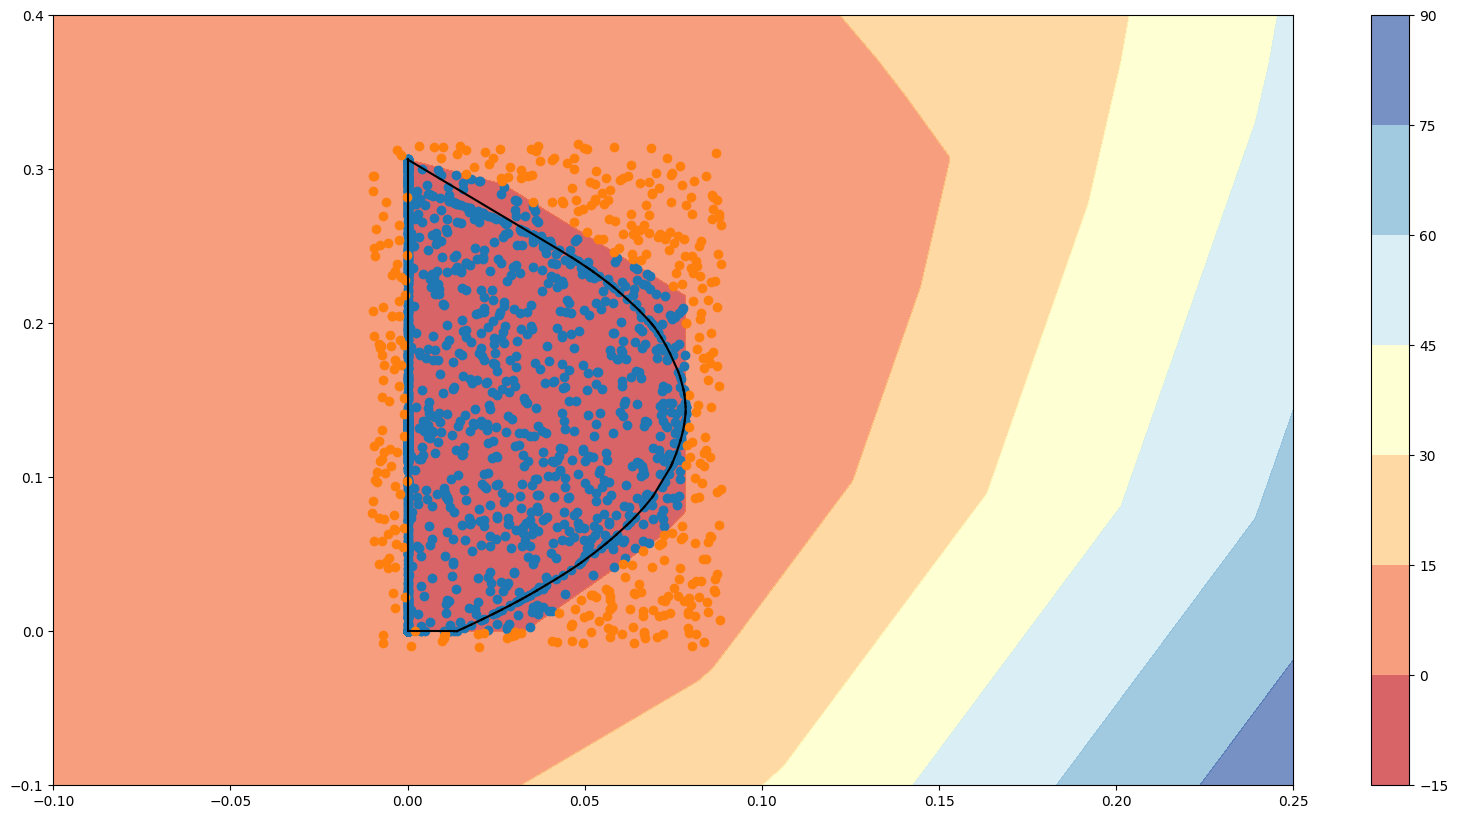

        time for verification: 1.630000352859497
    time for icnn_bound calculation: 0.18308115005493164
included space num samples 1152, ambient space num samples 848
    time for regrouping method: 3.1668195724487305

approximation of layer: 1
    number of fixed neurons for current layer: 24
    layer progress, group 1 of 3 
        time for sampling for one group: 7.6763670444488525


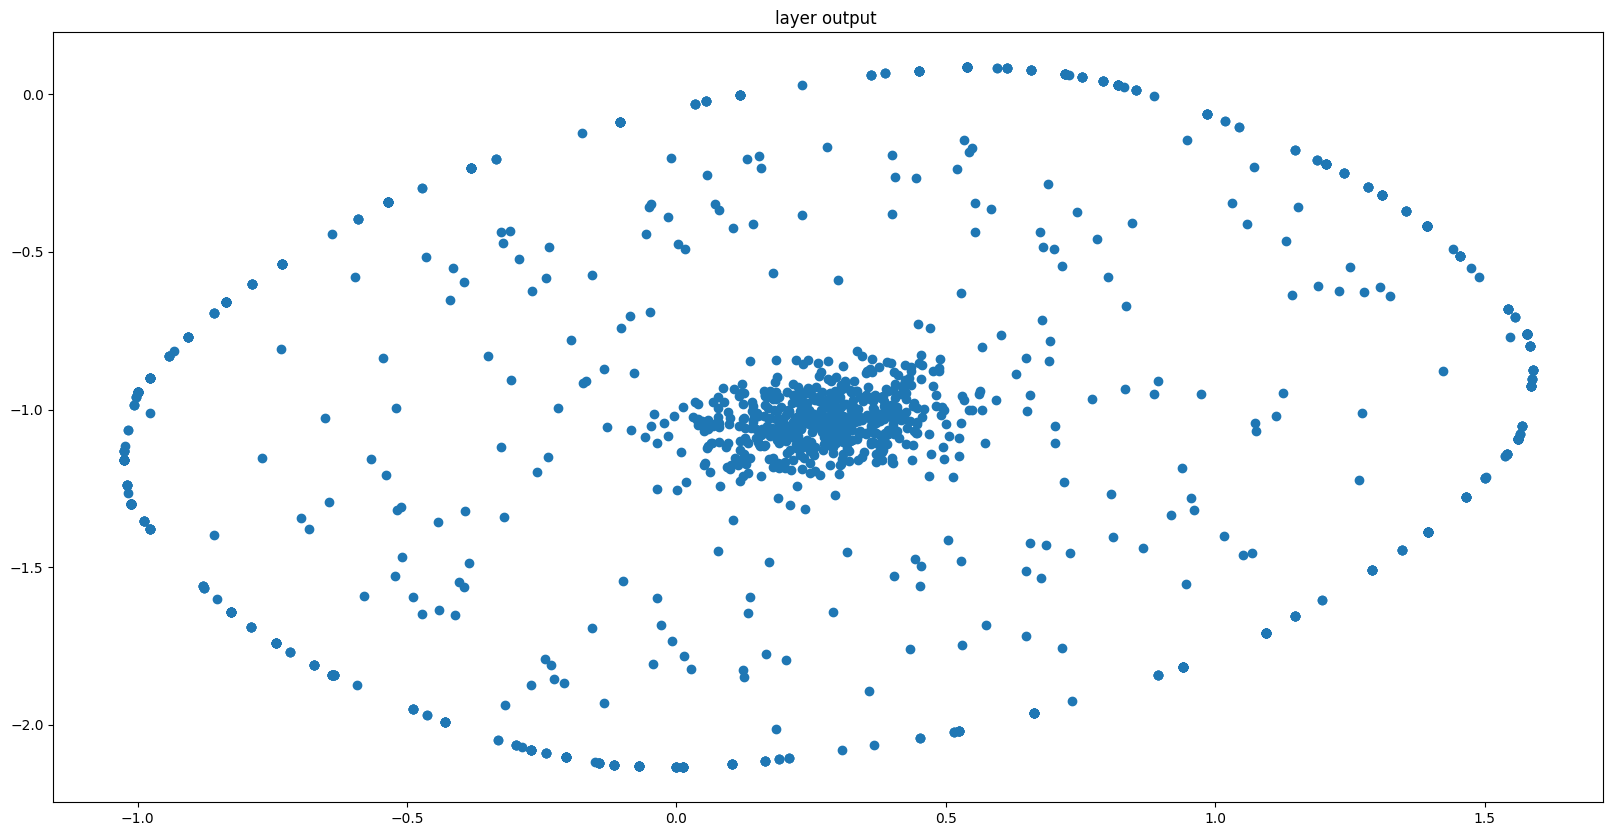

        time for training: 75.20366787910461
        actual verification time 0.01100301742553711


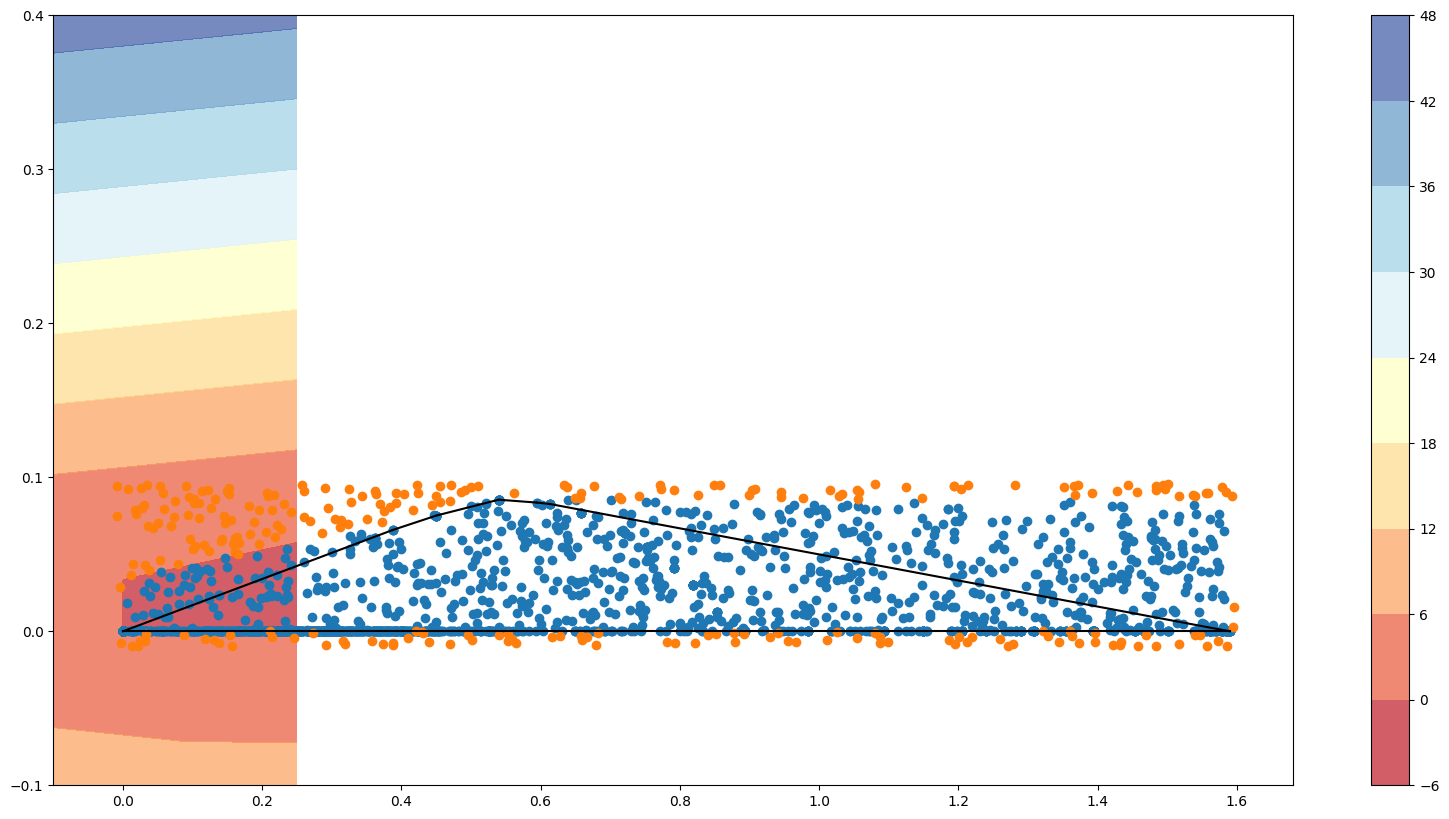

        time for verification: 1.4019994735717773
aborting because of force break


In [7]:
group_size = 2
icnn_factory = ICNNFactory("logical", [5, 5, 1], force_positive_init=False, with_two_layers=False,
                               init_scaling=10, init_all_with_zeros=False)
#icnn_factory = ICNNFactory("standard", [5, 5, 1])

icnns, all_group_indices, fixed_neuron_per_layer_lower, fixed_neuron_per_layer_upper, bounds_affine_out, bounds_layer_out = \
    multidhov.start_verification(nn, test_image, icnn_factory, group_size, eps=eps, icnn_epochs=1000,
                                     icnn_batch_size=1000, sample_count=2000, sample_new=True, use_over_approximation=True, break_after=5,
                                     sample_over_input_space=False, sample_over_output_space=True, use_icnn_bounds=True,
                                     use_fixed_neurons=True, sampling_method="per_group_sampling",
                                     force_inclusion_steps=0, preemptive_stop=False, even_gradient_training=False,
                                     keep_ambient_space=True, data_grad_descent_steps=0, opt_steps_gd=100,
                                     train_outer=False, print_training_loss=False,
                                     should_plot="none", optimizer="SdLBFGS", init_network=True, adapt_lambda="none")


In [8]:
print(bounds_affine_out[1][1])

tensor([ 1.5903,  6.9082,  2.4571, -2.6379,  3.3335,  0.0854,  2.2013,  0.5879,
         3.4414,  1.9512,  2.7689,  4.5998,  3.4715, -0.5237, -0.3061,  7.3616,
         2.0802,  4.2680, -0.2947,  6.6573,  1.2007,  7.4136,  3.3206,  6.7802,
         8.9711, -0.0464,  5.7120,  6.0631,  2.2935,  5.0945],
       dtype=torch.float64, grad_fn=<AddBackward0>)


In [9]:
input_flattened = torch.flatten(test_image)
bounds_affine_out, bounds_layer_out = nn.calculate_box_bounds([input_flattened.add(-eps), input_flattened.add(eps)])
print(bounds_affine_out[1][1])

tensor([ 1.5903,  6.9082,  2.4571, -2.6379,  3.3335,  0.0854,  2.2013,  0.5879,
         3.4414,  1.9512,  2.7689,  4.5998,  3.4715, -0.5237, -0.3061,  7.3616,
         2.0802,  4.2680, -0.2947,  6.6573,  1.2007,  7.4136,  3.3206,  6.7802,
         8.9711, -0.0464,  5.7120,  6.0631,  2.2935,  5.0945],
       dtype=torch.float64, grad_fn=<AddBackward0>)


In [10]:
dhov_model = icnn_model(icnns[layer_index][0], nn, test_image, eps, layer_index, 0, group_size, print_log=True)
dhov_model.update()

[0.70666748 0.         2.56957236 1.25056012 0.56577596 0.
 2.24672561 1.10036216 3.08457109 0.42557193 1.06481606 0.
 3.80799179 2.95306733 2.2914741  0.         1.45164122 3.88912043
 0.         0.65890114 3.78516924 2.54575045 0.33975505 0.
 0.30106137 0.         0.50057251 1.87296217 1.2716577  1.59314324
 0.         0.         2.42074295 0.         1.69313686 0.
 1.95689483 1.66914862 0.         0.27212066 2.14630917 1.68023284
 0.32191143 0.         0.28490208 0.78442567 0.2704539  1.098196
 0.68565325 1.74543125 2.29116924 0.         0.         1.77435549
 0.         2.77659388 0.         0.         1.21580995 0.
 0.         1.98215932 1.76104975 0.         4.24902551 1.01444244
 0.         0.         0.         0.         2.16896675 0.
 0.15547488 2.84610801 2.36071697 0.         0.         0.04042499
 0.         0.         0.         0.         0.         0.49566225
 0.         0.60572794 0.         1.69831855 1.74438874 2.23785683
 0.57627976 0.         0.93811607 0.         

In [11]:
icnn_neuron_name = "icnn_var[{}]".format(neuron_index)

In [12]:
dhov_copy = dhov_model.copy()
dhov_copy.Params.LogToConsole = 1
add_min_constr(dhov_copy, icnn_neuron_name)
dhov_copy.update()
all_var = dhov_copy.getVars()
optimize_model(dhov_copy, icnn_neuron_name)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 41 rows, 133 columns and 107 nonzeros
Model fingerprint: 0x9c4baa86
Model has 3 general constraints
Variable types: 133 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e-05, 5e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [3e+03, 2e+05]
  RHS range        [4e-04, 3e+00]
Presolve removed 24 rows and 114 columns
Presolve time: 0.00s
Presolved: 17 rows, 19 columns, 60 nonzeros
Variable types: 15 continuous, 4 integer (4 binary)
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.00

In [13]:
dhov_copy = dhov_model.copy()
dhov_copy.Params.LogToConsole = 0
add_max_constr(dhov_copy, icnn_neuron_name)
optimize_model(dhov_copy, icnn_neuron_name)

opt value: 1.590265447932639


Test for SNV

In [46]:
snv_verifier = SingleNeuronVerifier(nn, test_image, eps, print_log=False)
snv_verifier.generate_constraints_for_net()
snv_model = snv_verifier.model
snv_model.update()

In [47]:
snv_copy = snv_model.copy()
snv_copy.Params.LogToConsole = 0
add_min_constr(snv_copy, neuron_name)
optimize_model(snv_copy, neuron_name)

opt value: 0.0


In [48]:
snv_copy = snv_model.copy()
snv_copy.Params.LogToConsole = 0
add_max_constr(snv_copy, neuron_name)
optimize_model(snv_copy, neuron_name)

opt value: 2.625


Test for MILP

In [14]:
neuron_name = "relu_var{}[{}]".format(2*layer_index, 0)
milp_verifier = MILPVerifier(nn, test_image, eps, print_log=False)
milp_verifier.generate_constraints_for_net(until_layer_neuron=[layer_index, neuron_index])
milp_model = milp_verifier.model
milp_model.update()

"""all_var = milp_model.getVars()
for var in all_var:
    print(var)"""


'all_var = milp_model.getVars()\nfor var in all_var:\n    print(var)'

In [15]:
milp_copy = milp_model.copy()
milp_copy.Params.LogToConsole = 0
add_min_constr(milp_copy, neuron_name)
optimize_model(milp_copy, neuron_name)

opt value: 0.0


In [16]:
milp_copy = milp_model.copy()
milp_copy.Params.LogToConsole = 0
add_max_constr(milp_copy, neuron_name)
optimize_model(milp_copy, neuron_name)

opt value: 0.5622137652362753


In [27]:
in_var = []
for i in range(28*28):
    in_var.append(milp_copy.getVarByName("in_var[{}]".format(i)).getAttr("X"))

inp = torch.tensor(in_var, dtype=torch.float64)
par_list = list(nn.parameters())
first_out = torch.matmul(par_list[0], inp).add(par_list[1])
first_out = torch.nn.ReLU()(first_out)
second_out = torch.matmul(par_list[2], first_out).add(par_list[3])
print(second_out)

tensor([ 0.5622,  5.8829,  1.5250, -3.3748,  1.9779, -0.9429,  0.7452, -0.2541,
         2.2339,  1.0210,  1.7514,  3.4973,  2.4593, -1.1550, -0.8883,  5.9632,
         0.6167,  3.3430, -0.8186,  5.6432,  0.2598,  6.4190,  2.1272,  5.3496,
         7.6800, -0.5891,  4.6769,  4.7965,  1.4821,  4.0188],
       dtype=torch.float64, grad_fn=<AddBackward0>)


In [28]:
print(bounds_affine_out[1][1])

tensor([ 1.5903,  6.9082,  2.4571, -2.6379,  3.3335,  0.0854,  2.2013,  0.5879,
         3.4414,  1.9512,  2.7689,  4.5998,  3.4715, -0.5237, -0.3061,  7.3616,
         2.0802,  4.2680, -0.2947,  6.6573,  1.2007,  7.4136,  3.3206,  6.7802,
         8.9711, -0.0464,  5.7120,  6.0631,  2.2935,  5.0945],
       dtype=torch.float64, grad_fn=<AddBackward0>)
